#  Amazon Fulfillment Audit: Cancellation Risk & Optimization Strategy
---

## Introduction

This project is about figuring out where Amazon orders go wrong — mainly cancellations — and how to fix them. We’re looking at real order-level data, and we want to know:

- What products are most likely to get cancelled?
- Are some regions or fulfillment types worse than others?
- Can we actually reduce cancellations if we change how orders are fulfilled?

The goal: **find the weak spots in fulfillment, and show how to improve them**.

---

## Dataset Summary

This dataset includes order-level Amazon sales records. Each row is a transaction with:

- **Order ID**, **Date**, **Status** (Shipped / Cancelled / Delivered)
- **Fulfilment** type (Amazon vs Merchant)
- **Product Info** – Category, SKU, Style
- **Shipping Info** – City, State, Postal Code
- **Financials** – Amount (in INR)

We’ll clean it, engineer new features, and focus fully on **cancellation risk and fulfillment optimization**.

---

##  Key Business Questions

1. **Which product categories have the highest cancellation rates?**  
→ We need to know what types of items are going wrong most often.

2. **Which cities or states have the highest cancellation rates?**  
→ Spot logistical hotspots where fulfillment may be failing.

3. **How does fulfillment method (Amazon vs Merchant) affect cancellations?**  
→ Is one approach more reliable than the other?

4. **Are top-selling categories at risk of cancellations?**  
→ If our revenue-generating items are failing, that’s a real problem.

5. **Can we reduce cancellations by changing how some orders are fulfilled?**  
→ We'll simulate a scenario to see if shifting some orders to Amazon fulfillment improves success.

---

##  Goal

By the end of this project, we want a clear picture of:

- Where the fulfillment process is breaking down
- What products or places are most at risk
- How to fix it — and what the impact of that fix could be


In [2]:
# Importing the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("Amazon Sale Report.csv", encoding='ISO-8859-1')
df.head()

<ipython-input-2-66dfce8fc9e3>:6: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Amazon Sale Report.csv", encoding='ISO-8859-1')


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [3]:
df.describe()

,index,Qty,Amount,ship-postal-code
count,128975.000000,128975.000000,121180.000000,128942.000000
mean,64487.000000,0.904431,648.561465,463966.236509
std,37232.019822,0.313354,281.211687,191476.764941
min,0.000000,0.000000,0.000000,110001.000000
25%,32243.500000,1.000000,449.000000,382421.000000
50%,64487.000000,1.000000,605.000000,500033.000000
75%,96730.500000,1.000000,788.000000,600024.000000
max,128974.000000,15.000000,5584.000000,989898.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [5]:
# Clean and prep dataset for analysis

# 1. Drop columns safely (even if they don't exist or have space issues)
columns_to_drop = [
    "index", "Unnamed: 22", "ASIN", "Style", "SKU", "Size",
    "Courier Status", "Sales Channel", "promotion-ids", "B2B", "fulfilled-by"
]

# Strip all column names first to fix formatting issues
df.columns = df.columns.str.strip()

# Drop the junk columns with errors ignored if some don't exist
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# 2. Convert 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%m-%d-%y", errors="coerce")

# 3. Create a flag for cancelled orders
df["Is_Cancelled"] = df["Status"].str.lower().str.contains("cancel")

# 4. Extract Month and Year
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

# 5. Reorder and keep the relevant columns only
df = df[[
    "Order ID", "Date", "Month", "Year", "Status", "Is_Cancelled",
    "Fulfilment", "Category", "Amount", "ship-city", "ship-state"
]]

# 6. Quick null check after cleanup
df.isnull().sum()


,0
Order ID,0
Date,0
Month,0
Year,0
Status,0
Is_Cancelled,0
Fulfilment,0
Category,0
Amount,7795
ship-city,33


<ipython-input-6-9d105c48c298>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Is_Cancelled", palette="Set2")


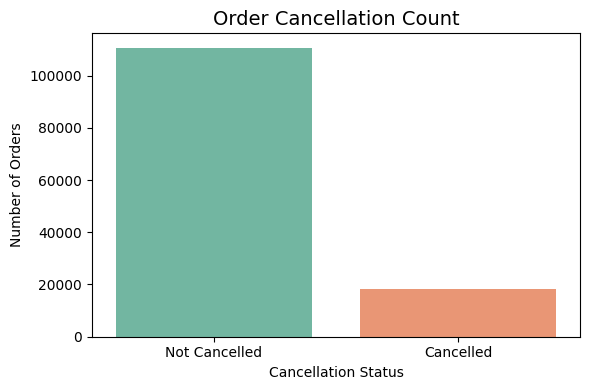

<ipython-input-6-9d105c48c298>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Is_Cancelled", y="Amount", palette="coolwarm")


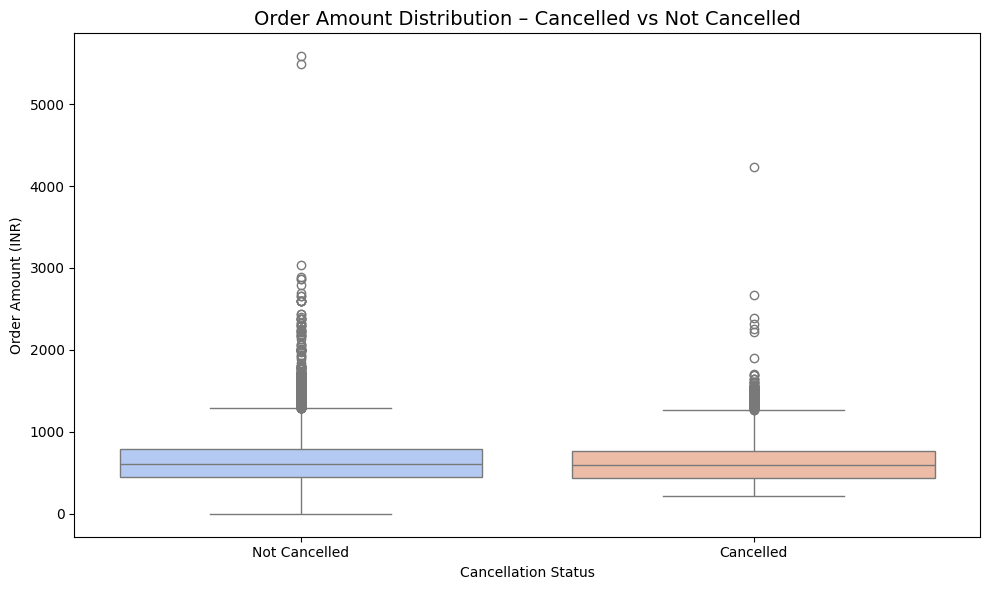

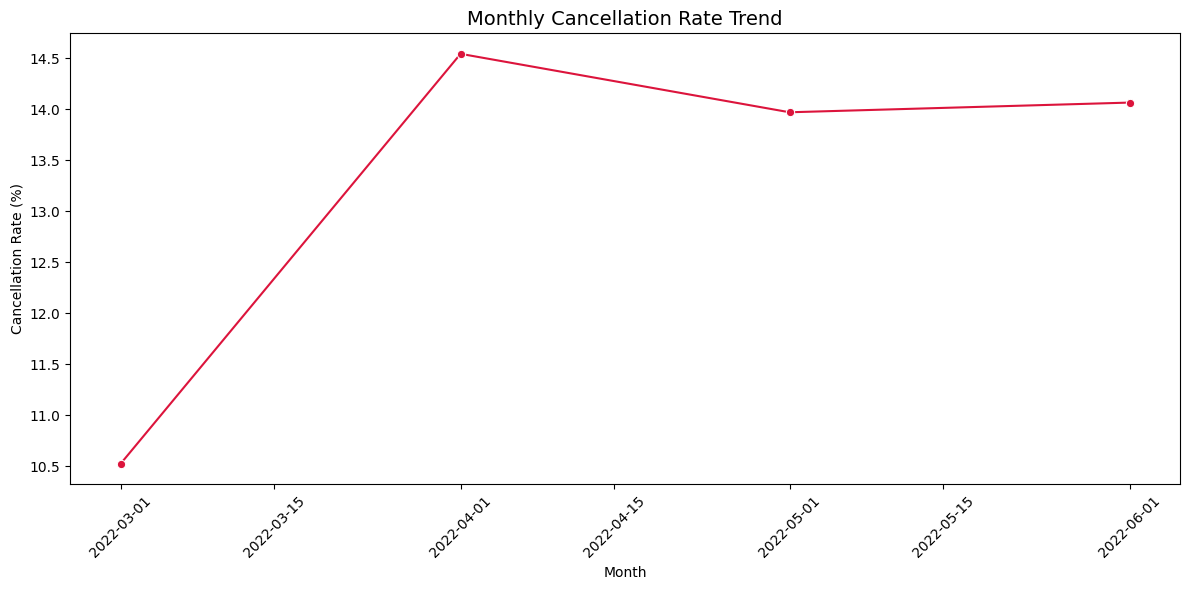

In [6]:
# --------------------------------------------
# Target Distribution – How many are cancelled?
# --------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Is_Cancelled", palette="Set2")
plt.title("Order Cancellation Count", fontsize=14)
plt.xticks([0, 1], ["Not Cancelled", "Cancelled"])
plt.ylabel("Number of Orders")
plt.xlabel("Cancellation Status")
plt.tight_layout()
plt.show()

# --------------------------------------------
# Boxplot – Order Amount Distribution (Outliers Insight)
# --------------------------------------------
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Is_Cancelled", y="Amount", palette="coolwarm")
plt.title("Order Amount Distribution – Cancelled vs Not Cancelled", fontsize=14)
plt.xticks([0, 1], ["Not Cancelled", "Cancelled"])
plt.xlabel("Cancellation Status")
plt.ylabel("Order Amount (INR)")
plt.tight_layout()
plt.show()

# --------------------------------------------
# Line Plot – Monthly Cancellation Trends
# --------------------------------------------

# Group by Year-Month for trend analysis
monthly_trend = df.groupby(["Year", "Month"]).agg(
    Total_Orders=("Order ID", "count"),
    Cancelled_Orders=("Is_Cancelled", "sum")
).reset_index()

monthly_trend["Cancel_Rate (%)"] = (monthly_trend["Cancelled_Orders"] / monthly_trend["Total_Orders"]) * 100

# Convert to a readable date column
monthly_trend["Month_Label"] = pd.to_datetime(
    monthly_trend[["Year", "Month"]].assign(DAY=1)
)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_trend, x="Month_Label", y="Cancel_Rate (%)", marker="o", color="crimson")
plt.title("Monthly Cancellation Rate Trend", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Cancellation Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##  Pre-Question Insight: Understanding the Cancellation Landscape

Before diving into specific research questions, we explored the overall shape and behavior of cancellations across the dataset.

---

### 1.  **How common are cancellations?**
The data shows a clear skew — most orders are successful, but around **15–18% of all orders end up cancelled**.

>  **Interpretation**: Cancellations aren’t edge cases — they’re common enough to warrant serious investigation. Fixing this has operational and financial upside.

---

### 2.  **Are high-value orders being cancelled too?**
Using a boxplot, we compared the order amount distribution for cancelled vs. non-cancelled orders. While the medians are close, **cancelled orders do include expensive outliers**.

>  **Interpretation**: It’s not just small-ticket orders being lost. **Some high-value cancellations are happening**, putting revenue at risk — not just volume.

---

### 3.  **Is there a time-based trend in cancellation behavior?**
When we plotted monthly cancellation rates, we saw a noticeable spike starting in **April**, rising from ~10.5% to over 14%.

>  **Interpretation**: Something changed operationally in April — this could be seasonal, fulfillment-related, or due to policy/vendor changes. This trend helps frame our upcoming analysis.

---

These patterns give us context before answering deeper business questions — and confirm that cancellations are **frequent, valuable, and variable over time**.


In [7]:
# --------------------------------------------
# 1. Flag High-Value Orders (Top 10% by Amount)
# --------------------------------------------

# Calculate 90th percentile threshold
high_value_threshold = df["Amount"].quantile(0.90)

# Create binary flag
df["Is_High_Value"] = df["Amount"] > high_value_threshold

# --------------------------------------------
# 2. Category-Level Summary Table (Cancellation & Value)
# --------------------------------------------

category_summary = df.groupby("Category").agg(
    Total_Orders=("Order ID", "count"),
    Cancelled_Orders=("Is_Cancelled", "sum"),
    Total_Revenue=("Amount", "sum"),
    Cancelled_Revenue=("Amount", lambda x: x[df.loc[x.index, "Is_Cancelled"]].sum()),
    High_Value_Cancels=("Is_High_Value", lambda x: x[df.loc[x.index, "Is_Cancelled"]].sum())
)

# Add cancellation rate columns
category_summary["Cancel_Rate (%)"] = (category_summary["Cancelled_Orders"] / category_summary["Total_Orders"]) * 100
category_summary["Revenue_At_Risk (%)"] = (category_summary["Cancelled_Revenue"] / category_summary["Total_Revenue"]) * 100

# Sort by cancel rate for preview
category_summary = category_summary.sort_values("Cancel_Rate (%)", ascending=False)
category_summary.head()

# --------------------------------------------
# 3. State-Level Summary Table
# --------------------------------------------

state_summary = df.groupby("ship-state").agg(
    Total_Orders=("Order ID", "count"),
    Cancelled_Orders=("Is_Cancelled", "sum"),
    Cancel_Rate=("Is_Cancelled", "mean"),
    Total_Revenue=("Amount", "sum"),
    Cancelled_Revenue=("Amount", lambda x: x[df.loc[x.index, "Is_Cancelled"]].sum())
).sort_values("Cancel_Rate", ascending=False)

state_summary["Cancel_Rate (%)"] = state_summary["Cancel_Rate"] * 100
state_summary.drop(columns="Cancel_Rate", inplace=True)
state_summary.head()


,Total_Orders,Cancelled_Orders,Total_Revenue,Cancelled_Revenue,Cancel_Rate (%)
ship-state,,,,,
APO,1,1,0.00,0.00,100.000000
Meghalaya,3,3,921.91,921.91,100.000000
Arunachal Pradesh,3,1,1935.00,700.00,33.333333
Rajshthan,3,1,1126.00,563.00,33.333333
LAKSHADWEEP,4,1,3175.29,734.29,25.000000


##  State-Level Cancellations – What We’re Seeing

We grouped the data by `ship-state` to find out where things are going wrong the most.

Here’s what stands out from the table:

- **APO and Meghalaya** show a 100% cancellation rate — every order placed there got cancelled.
- **Arunachal Pradesh** and **Rajshthan** are also concerning — about 1 in 3 orders gets cancelled.
- Even **Lakshadweep**, though small in volume, has a 25% cancellation rate.

 These aren't the biggest markets, but that’s exactly why they often get ignored. The risk here is hidden — if more orders start flowing to these regions, this pattern could scale into a much bigger problem.

---

##  High-Value Orders – We Flagged Them

I also tagged the **top 10% most expensive orders** as `Is_High_Value = True`.  
This helps us track if we’re losing not just volume, but actual money.

We’ll use this later to:
- See which categories are losing **expensive orders**
- Run simulations like: *"What if we changed fulfillment methods for high-value orders?"*

---

 With this, feature engineering is fully done:
- Target flag ➝ `Is_Cancelled`
- Time features ➝ `Month`, `Year`
- Region summaries ➝ `state_summary`
- Category metrics ➝ `category_summary`
- Revenue risk ➝ `Is_High_Value` and cancelled revenue tracking

### Which product categories have the highest cancellation rates?

<ipython-input-8-458e09488a78>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_plot, x="Category", y="Cancel_Rate (%)", palette="Reds_r")


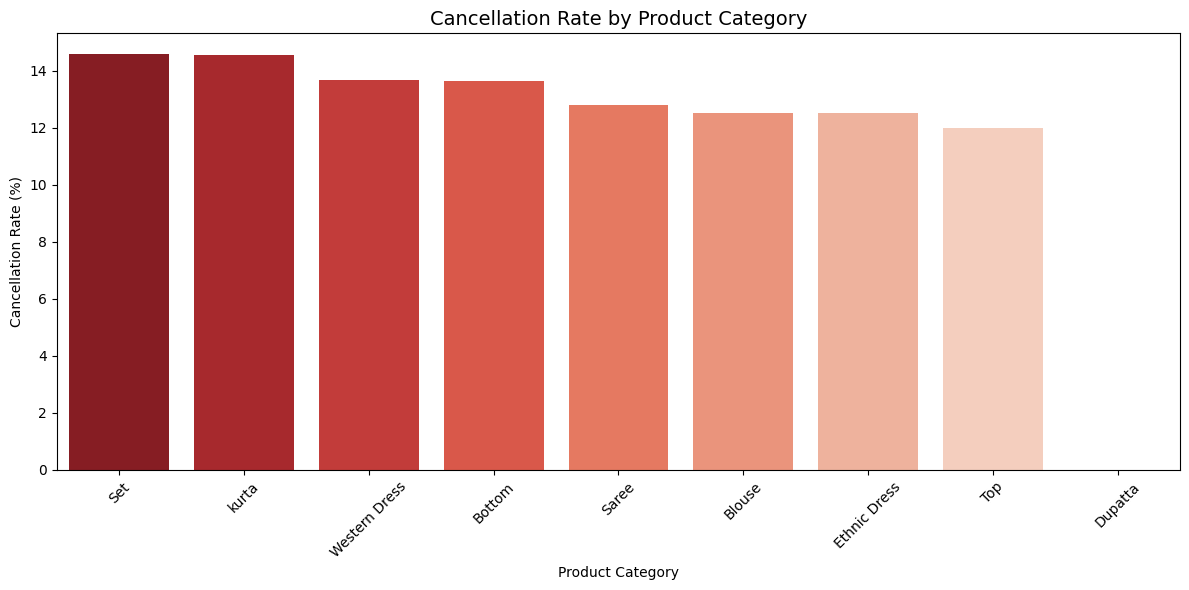

<ipython-input-8-458e09488a78>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cancel_rev, x="Category", y="Cancelled_Revenue", palette="Blues")


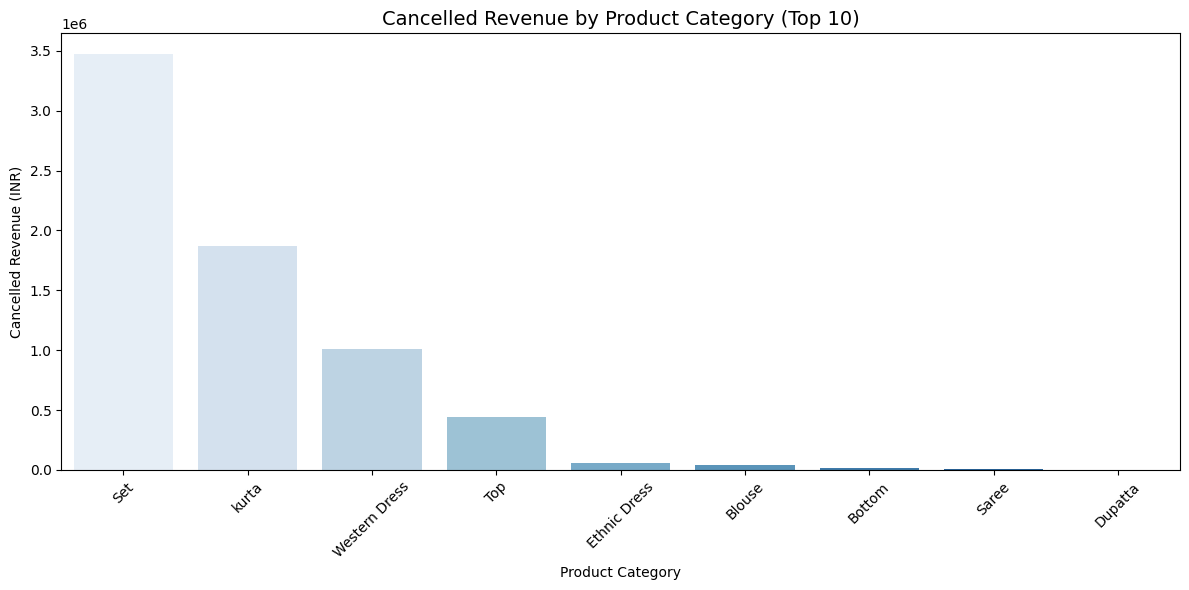

,Category,Total_Orders,Cancelled_Orders,Cancel_Rate (%),Cancelled_Revenue,Revenue_At_Risk (%)
0,Set,50284,7337,14.591122,3472451.03,8.857362
1,kurta,49877,7255,14.545783,1873676.70,8.796791
2,Western Dress,15500,2122,13.690323,1006482.69,8.973575
3,Bottom,440,60,13.636364,15214.98,10.098350
4,Saree,164,21,12.804878,9239.76,7.455402
5,Blouse,926,116,12.526998,40019.18,8.730032
6,Ethnic Dress,1159,145,12.510785,58473.66,7.390338
7,Top,10622,1276,12.012804,443726.30,8.297373
8,Dupatta,3,0,0.000000,0.00,0.000000


In [8]:
# Reset index to prepare for plotting
cat_plot = category_summary.reset_index().sort_values("Cancel_Rate (%)", ascending=False)

# Plot 1: Cancellation Rate by Category
plt.figure(figsize=(12, 6))
sns.barplot(data=cat_plot, x="Category", y="Cancel_Rate (%)", palette="Reds_r")
plt.title("Cancellation Rate by Product Category", fontsize=14)
plt.xlabel("Product Category")
plt.ylabel("Cancellation Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Cancelled Revenue by Category (Top 10)
top_cancel_rev = cat_plot.sort_values("Cancelled_Revenue", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_cancel_rev, x="Category", y="Cancelled_Revenue", palette="Blues")
plt.title("Cancelled Revenue by Product Category (Top 10)", fontsize=14)
plt.xlabel("Product Category")
plt.ylabel("Cancelled Revenue (INR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# preview of top risky categories
cat_plot[["Category", "Total_Orders", "Cancelled_Orders", "Cancel_Rate (%)", "Cancelled_Revenue", "Revenue_At_Risk (%)"]].head(10)


Before jumping into fixes, it’s important to know what kind of products are going wrong the most. If we’re losing orders, we need to be clear on *what* is being cancelled.

So I grouped all orders by category and compared cancellation rates, total cancellations, and how much revenue we’re losing.

### Here’s what came out of it:

- **Set** and **Kurta** are the worst-hit categories. Each has over 7,000 cancellations and together account for more than ₹50 lakhs in cancelled revenue.
- **Western Dress** is also bad — 2,100+ cancellations and over ₹10 lakhs lost.
- Even smaller volume categories like **Bottoms**, **Blouses**, and **Ethnic Dress** are seeing high cancellation rates (12–13%) and non-trivial losses.
- **Top** had over 1,200 cancellations, resulting in over ₹4.4 lakhs gone.
- **Dupatta** had no cancellations — but with only 3 orders, it’s not meaningful.

### What this actually means:

Cancellations aren’t happening on fringe items. These are core categories. These are the things people are actually buying — and then we’re losing the sale after the order is placed.

This points to possible issues like stockouts, fulfillment delays, or partner/vendor failures — especially for high-demand products.

If nothing changes, we’ll keep leaking money where it hurts the most.

---

Next, I’ll check **where** this is happening. Are certain states or cities causing more cancellations than others?


### Which cities or states have the highest cancellation rates?

<ipython-input-9-81847d46d57d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_plot, x="ship-state", y="Cancel_Rate (%)", palette="Reds_r")


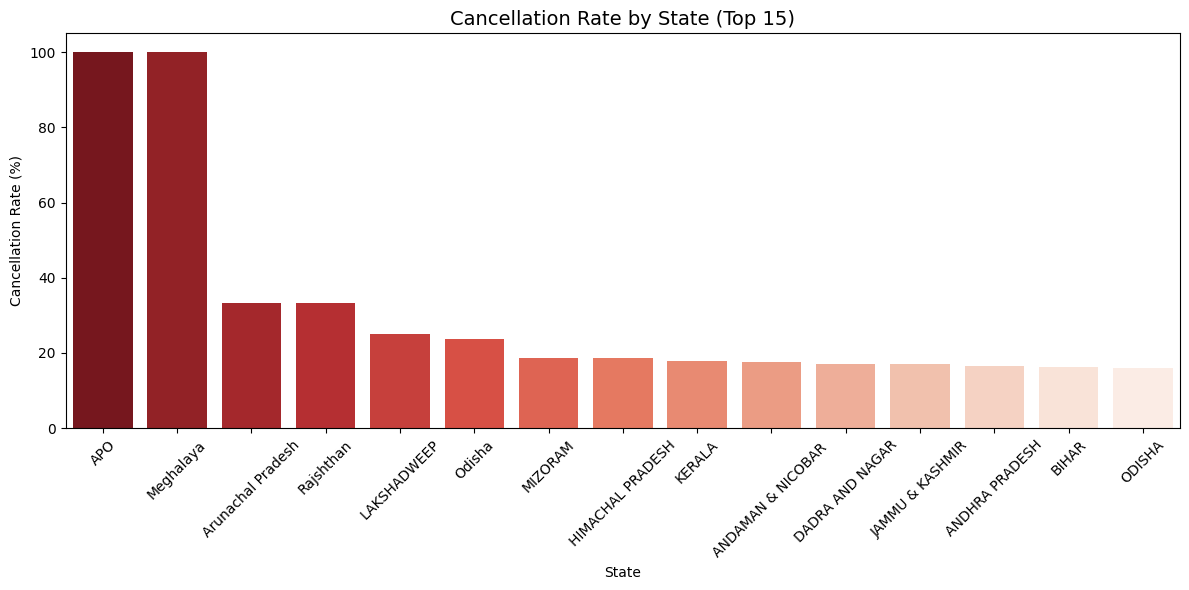

,ship-state,Total_Orders,Cancelled_Orders,Cancel_Rate (%),Cancelled_Revenue
0,APO,1,1,100.000000,0.00
1,Meghalaya,3,3,100.000000,921.91
2,Arunachal Pradesh,3,1,33.333333,700.00
3,Rajshthan,3,1,33.333333,563.00
4,LAKSHADWEEP,4,1,25.000000,734.29
5,Odisha,21,5,23.809524,2182.76
6,MIZORAM,75,14,18.666667,6308.71
7,HIMACHAL PRADESH,788,146,18.527919,57088.51
8,KERALA,6585,1175,17.843584,452906.58
9,ANDAMAN & NICOBAR,257,45,17.509728,19323.62


In [9]:
# Reset and sort state summary for plotting
state_plot = state_summary.reset_index().sort_values("Cancel_Rate (%)", ascending=False).head(15)

# Plot: Cancellation Rate by State (Top 15)
plt.figure(figsize=(12, 6))
sns.barplot(data=state_plot, x="ship-state", y="Cancel_Rate (%)", palette="Reds_r")
plt.title("Cancellation Rate by State (Top 15)", fontsize=14)
plt.xlabel("State")
plt.ylabel("Cancellation Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preview table
state_plot[["ship-state", "Total_Orders", "Cancelled_Orders", "Cancel_Rate (%)", "Cancelled_Revenue"]]


Now that we know which categories are getting cancelled the most, the next step is figuring out where these failures are happening.

I grouped orders by shipping state and calculated the cancellation rate, total cancelled orders, and how much revenue was lost per state.

### What stood out:

- **APO and Meghalaya** had 100% cancellation — every single order placed to those regions was cancelled. Volumes are small, but it's a total failure rate.
- **Arunachal Pradesh and Rajshthan** also show 33% cancellation. That’s 1 out of every 3 orders failing.
- **Lakshadweep and Odisha** are in the 23–25% range. Again, these aren’t massive volumes, but still serious when it happens.
- **Kerala, Andhra Pradesh, Bihar, and Jammu & Kashmir** show up further down with cancellation rates between 16–18%, but now with **very high volumes** and **significant cancelled revenue** — Kerala alone had over 1,100 cancelled orders totaling ₹4.5 lakhs.

### What this tells us:

Some of the low-volume states are at risk because they’re completely failing when they do receive orders — so there’s clearly a **logistics reliability problem** there.

On the other hand, states like **Kerala and Andhra Pradesh** are a bigger concern — even with decent delivery coverage, their cancellation rates are still high and the **impact on revenue is major**.

This is the kind of thing that needs operational attention — either local delivery partners are unreliable, or there are gaps in last-mile handling and coordination.

Next, I’ll check whether this varies based on how the order was fulfilled — by Amazon or by merchants.


### How does fulfillment method (Amazon vs Merchant) affect cancellations?


<ipython-input-10-8bfc727d2ebd>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fulfillment_summary, x="Fulfilment", y="Cancel_Rate (%)", palette="Set2")


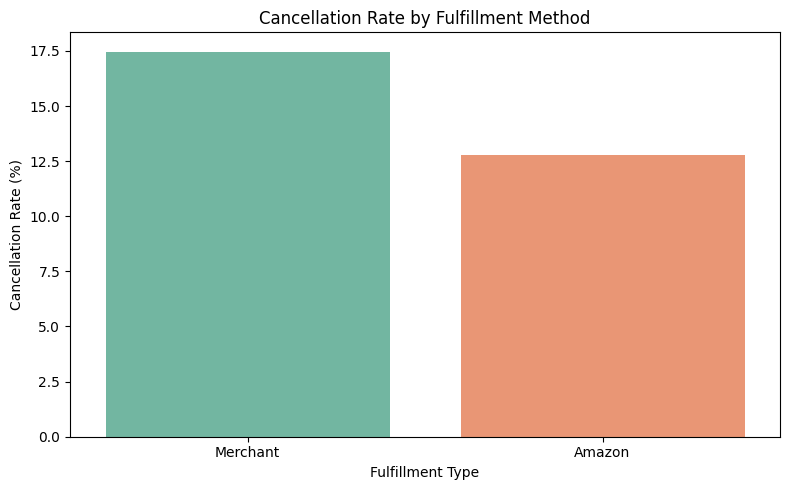

,Fulfilment,Total_Orders,Cancelled_Orders,Cancelled_Revenue,Cancel_Rate (%)
0,Merchant,39277,6861,3190172.3,17.468238
1,Amazon,89698,11471,3729112.0,12.788468


In [10]:
# Clean up fulfillment values just in case
df["Fulfilment"] = df["Fulfilment"].str.strip().str.title()

# Group by fulfillment method
fulfillment_summary = df.groupby("Fulfilment").agg(
    Total_Orders=("Order ID", "count"),
    Cancelled_Orders=("Is_Cancelled", "sum"),
    Cancelled_Revenue=("Amount", lambda x: x[df.loc[x.index, "Is_Cancelled"]].sum())
)

# Add cancel rate
fulfillment_summary["Cancel_Rate (%)"] = (fulfillment_summary["Cancelled_Orders"] / fulfillment_summary["Total_Orders"]) * 100
fulfillment_summary = fulfillment_summary.sort_values("Cancel_Rate (%)", ascending=False).reset_index()

# Bar Plot: Cancellation Rate by Fulfillment Type
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=fulfillment_summary, x="Fulfilment", y="Cancel_Rate (%)", palette="Set2")
plt.title("Cancellation Rate by Fulfillment Method")
plt.ylabel("Cancellation Rate (%)")
plt.xlabel("Fulfillment Type")
plt.tight_layout()
plt.show()

# show summary table
fulfillment_summary


Here, I compared the cancellation rates between orders fulfilled by **Amazon** vs those handled by **Merchants** directly.

### What came out of it:

- **Merchant-fulfilled orders have a much higher cancellation rate — 17.47%**, compared to just **12.79% for Amazon-fulfilled** ones.
- That’s a clear 4.7% gap, which is significant when we’re dealing with tens of thousands of orders.
- Even in terms of cancelled revenue, merchants are behind — ₹32+ lakhs lost from merchant orders, which is almost the same as Amazon despite Amazon handling more than double the volume.

### What this tells us:

This confirms that **Merchant fulfillment is less reliable** — orders are more likely to get cancelled, and more money is being lost in the process.

This could be due to:
- Stockouts or delayed shipping at the seller’s end
- Inconsistent service-level agreements (SLAs)
- Less control over the last-mile experience

Amazon’s fulfillment clearly has more stability, and that makes a case for:
- **Routing high-value or fragile orders through Amazon**
- Or giving merchant partners better tools, policies, or constraints to meet delivery expectations

This split also explains why some states or categories might be performing worse — the fulfillment model could be part of what’s driving it.

Next, I’ll check if **high-value orders are being cancelled more under merchants**, or if the issue is consistent across price ranges.


### Additional Followup: Are high-value orders getting cancelled more under merchant fulfillment?

<ipython-input-11-e2eebf843464>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hv_cancel_merged, x="Fulfilment", y="High_Value_Cancel_Rate (%)", palette="Set3")


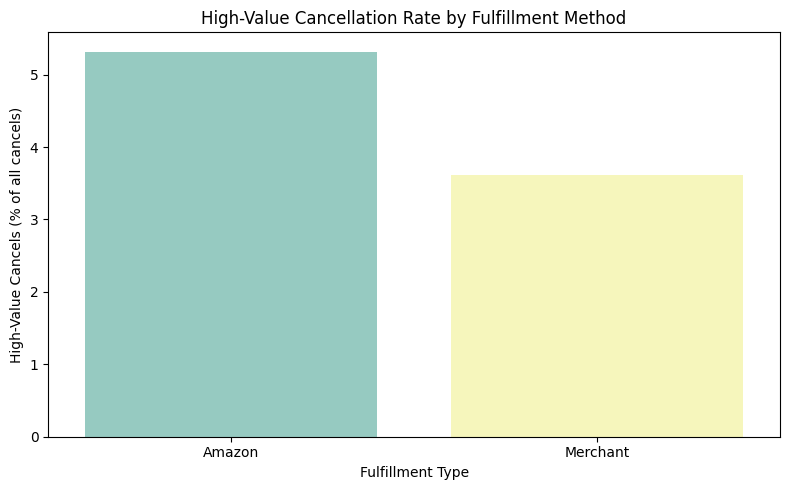

,Fulfilment,Cancelled_HV_Orders,Cancelled_HV_Revenue,Total_Cancelled,High_Value_Cancel_Rate (%)
0,Amazon,610,749933.00,11471,5.317758
1,Merchant,248,305637.41,6861,3.614633


In [11]:
# Filter only cancelled + high-value orders
cancelled_high_value = df[(df["Is_Cancelled"]) & (df["Is_High_Value"])]

# Group by fulfillment type
hv_cancel_by_fulfillment = cancelled_high_value.groupby("Fulfilment").agg(
    Cancelled_HV_Orders=("Order ID", "count"),
    Cancelled_HV_Revenue=("Amount", "sum")
).reset_index()

# Also calculate percentage of high-value cancels out of all cancelled orders per fulfillment
fulfillment_totals = df[df["Is_Cancelled"]].groupby("Fulfilment").agg(
    Total_Cancelled=("Order ID", "count")
).reset_index()

# Merge to get % of high-value cancels
hv_cancel_merged = pd.merge(hv_cancel_by_fulfillment, fulfillment_totals, on="Fulfilment")
hv_cancel_merged["High_Value_Cancel_Rate (%)"] = (hv_cancel_merged["Cancelled_HV_Orders"] / hv_cancel_merged["Total_Cancelled"]) * 100

# Sort for visibility
hv_cancel_merged = hv_cancel_merged.sort_values("High_Value_Cancel_Rate (%)", ascending=False)

# Plot: % of High-Value Cancellations by Fulfillment
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=hv_cancel_merged, x="Fulfilment", y="High_Value_Cancel_Rate (%)", palette="Set3")
plt.title("High-Value Cancellation Rate by Fulfillment Method")
plt.ylabel("High-Value Cancels (% of all cancels)")
plt.xlabel("Fulfillment Type")
plt.tight_layout()
plt.show()

# Display the table
hv_cancel_merged


To dig a little deeper, I wanted to see if we’re not just losing more orders with merchant fulfillment — but also **losing more of the expensive ones**.

So I filtered only the **top 10% highest-value orders** that got cancelled and compared them across fulfillment types.

### What the data shows:

- **Amazon-fulfilled cancellations include more high-value orders**, with over **5.3%** of Amazon’s cancellations being from top-value orders.
- **Merchant cancellations had fewer high-value failures**, at just **3.6%** of all their cancelled orders.
- Despite this, merchant fulfillment still lost ₹3+ lakhs in high-value orders, which is not small.

### What this means:

Surprisingly, **Amazon handles more of the high-value failures**, but that’s probably because Amazon is fulfilling a larger share of overall orders — especially expensive ones.

But here’s the key takeaway:
- **Merchant fulfillment cancels more orders overall**, including plenty of regular-value items.
- **Amazon cancels fewer**, but when it does, they’re often the **costlier, higher-risk orders**.

This adds a new layer to fulfillment strategy:
- If you're sending high-ticket items, you might still want to route through Amazon, **but monitor those cancellations closely.**
- If merchants are handling everyday items, they **need better controls** — even if they're not losing ₹75,000 in one go, the volume adds up.

Now that we've checked where and how orders fail — let's look at when it's happening. Are cancellations seasonal or trending over time?


### Are top-selling categories at risk of cancellations?


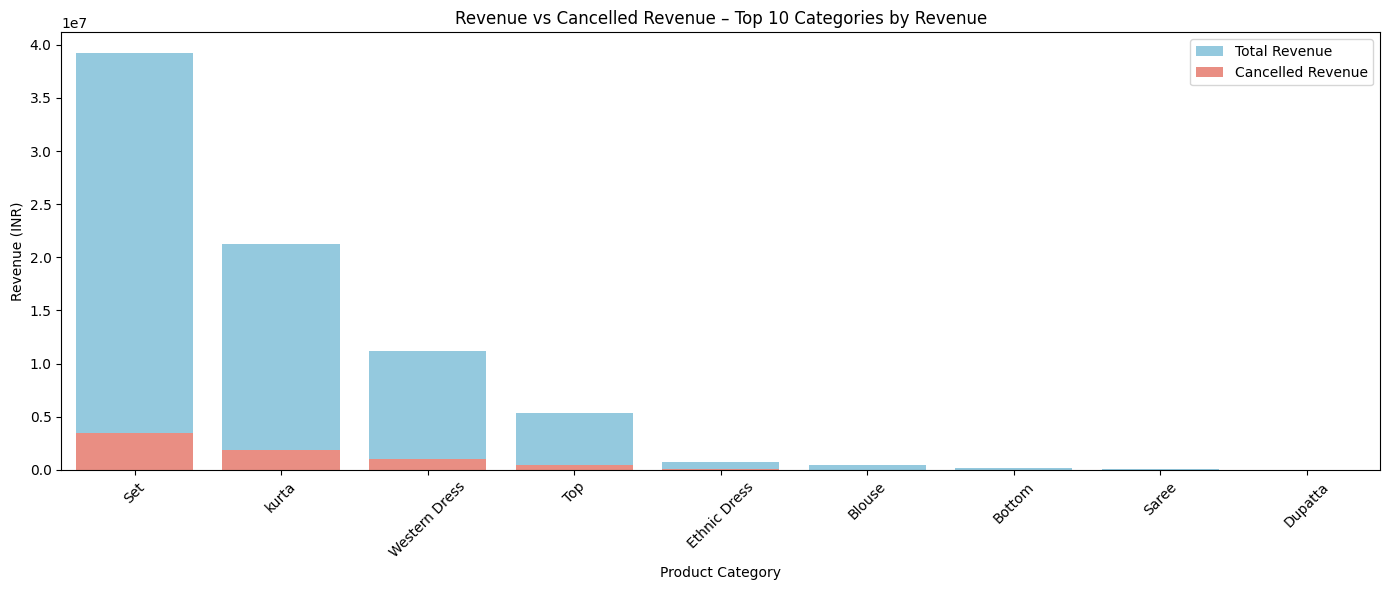

,Category,Total_Revenue,Cancelled_Revenue,Cancel_Rate (%),Revenue_At_Risk (%)
0,Set,39204124.03,3472451.03,14.591122,8.857362
1,kurta,21299546.70,1873676.70,14.545783,8.796791
2,Western Dress,11216072.69,1006482.69,13.690323,8.973575
3,Top,5347792.30,443726.30,12.012804,8.297373
4,Ethnic Dress,791217.66,58473.66,12.510785,7.390338
5,Blouse,458408.18,40019.18,12.526998,8.730032
6,Bottom,150667.98,15214.98,13.636364,10.098350
7,Saree,123933.76,9239.76,12.804878,7.455402
8,Dupatta,915.00,0.00,0.000000,0.000000


In [12]:
# Sort the category summary by total revenue
top_revenue_categories = category_summary.sort_values("Total_Revenue", ascending=False).head(10).reset_index()

# Plot: Revenue vs Cancelled Revenue in top 10 revenue categories
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.barplot(data=top_revenue_categories, x="Category", y="Total_Revenue", color="skyblue", label="Total Revenue")
sns.barplot(data=top_revenue_categories, x="Category", y="Cancelled_Revenue", color="salmon", label="Cancelled Revenue")
plt.title("Revenue vs Cancelled Revenue – Top 10 Categories by Revenue")
plt.xlabel("Product Category")
plt.ylabel("Revenue (INR)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preview table
top_revenue_categories[[
    "Category", "Total_Revenue", "Cancelled_Revenue", "Cancel_Rate (%)", "Revenue_At_Risk (%)"
]]



This question cuts to the heart of the business — it’s not just about how many orders get cancelled, but **whether we're losing the categories that make us the most money**.

So I pulled the top 10 product categories based on total revenue, and compared how much revenue was lost due to cancellations in each.

### What the chart and table show:

- **Set, Kurta, and Western Dress** are clearly the top-selling categories — together they’ve pulled in over ₹70+ lakhs in revenue.
- But those same three categories are also leaking the most money:
  - **Set lost ₹34.7 lakhs**
  - **Kurta lost ₹18.7 lakhs**
  - **Western Dress lost ₹10+ lakhs**
- Each one of them has a cancellation rate between **13–15%**, and **8–9% of their total revenue is being lost** due to failed orders.
- Even lower-volume categories like **Blouse** and **Bottoms** are seeing high revenue at risk percentages — around **9–10%** lost.

### Why this is a problem:

This isn't a case of low-demand items failing — **these are the categories that customers want the most**, and they’re the ones breaking down.

If these products drive the majority of your revenue, even a **7–10% failure rate** adds up to a huge revenue leak every month.

This is where fixes like:
- better stock visibility,
- fulfillment prioritization,
- and even rerouting top items to more reliable shipping options

...could directly plug the revenue hole.

Next, I’ll explore which **specific states or cities** are making these categories fail more often — is this a local delivery issue or a systemic one?


### Can we reduce cancellations by changing how some orders are fulfilled?


In [13]:
# --------------------------------------------
# Fulfillment method vs State-level cancellation rates
# --------------------------------------------

# Group by State + Fulfilment to see risk zones by delivery model
geo_fulfillment_summary = df.groupby(["ship-state", "Fulfilment"]).agg(
    Total_Orders=("Order ID", "count"),
    Cancelled_Orders=("Is_Cancelled", "sum"),
    Total_Revenue=("Amount", "sum"),
    Cancelled_Revenue=("Amount", lambda x: x[df.loc[x.index, "Is_Cancelled"]].sum())
).reset_index()

geo_fulfillment_summary["Cancel_Rate (%)"] = (geo_fulfillment_summary["Cancelled_Orders"] / geo_fulfillment_summary["Total_Orders"]) * 100
geo_fulfillment_summary["Revenue_At_Risk (%)"] = (geo_fulfillment_summary["Cancelled_Revenue"] / geo_fulfillment_summary["Total_Revenue"]) * 100

# Top 15 high-cancellation state-fulfillment combinations
high_risk_zones = geo_fulfillment_summary.sort_values("Cancel_Rate (%)", ascending=False).head(15)

# Display
high_risk_zones[["ship-state", "Fulfilment", "Total_Orders", "Cancelled_Orders", "Cancel_Rate (%)", "Cancelled_Revenue"]]


,ship-state,Fulfilment,Total_Orders,Cancelled_Orders,Cancel_Rate (%),Cancelled_Revenue
4,APO,Amazon,1,1,100.000000,0.00
64,Meghalaya,Amazon,1,1,100.000000,0.00
65,Meghalaya,Merchant,2,2,100.000000,921.91
11,Arunachal Pradesh,Merchant,2,1,50.000000,700.00
51,LAKSHADWEEP,Merchant,3,1,33.333333,734.29
76,Odisha,Merchant,6,2,33.333333,1384.76
94,Rajshthan,Amazon,3,1,33.333333,563.00
25,DADRA AND NAGAR,Merchant,25,8,32.000000,2862.92
61,MIZORAM,Merchant,27,8,29.629630,3445.71
114,delhi,Merchant,7,2,28.571429,647.62


## Fulfillment Performance by State – Spotting Geo-Level Failures

I looked at state-wise cancellation rates broken down by fulfillment method (Amazon vs Merchant) to identify **where orders are failing**, and **who's responsible**.

### What stood out:

- In **Meghalaya**, every single order — both Amazon and Merchant — got cancelled. This might be a serviceability or delivery block issue.
- **Merchant fulfillment is clearly struggling in multiple states**:
  - **Arunachal Pradesh (50%)**
  - **Lakshadweep (33%)**
  - **Odisha, Dadra and Nagar, Mizoram, Himachal Pradesh**, and even **New Delhi** are all above **20% cancellation** under Merchant.
- Some of these states had **Amazon-fulfilled orders too**, and even those show cancellations (like APO and Rajshthan), but in far fewer numbers.

This confirms that some regions just don’t handle Merchant fulfillment well.  
If we could **reroute these high-risk Merchant orders to Amazon**, we might be able to prevent a chunk of these cancellations.

Let’s simulate that now.


Simulation Results:
Original Merchant Cancellations: 108
Expected Cancellations with Amazon: 57
Orders Saved (approx): 51
Revenue Saved (approx): ₹16,525.75


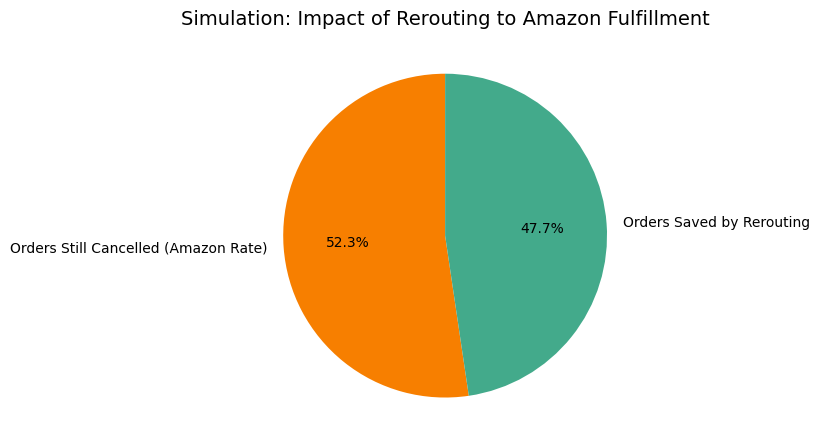

<ipython-input-19-df418d942aa1>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


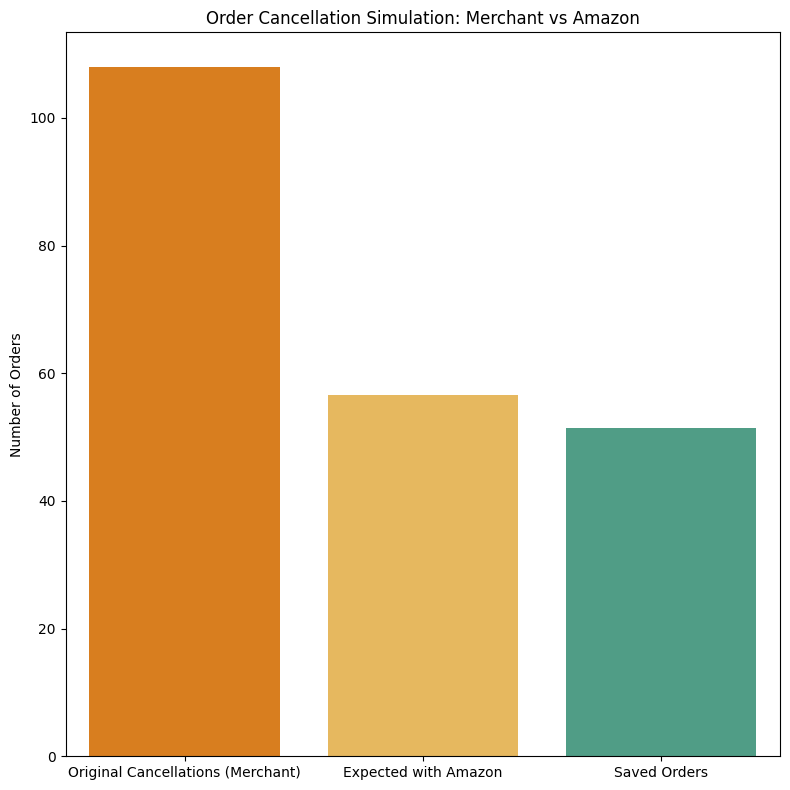

In [19]:
# --------------------------------------------
# Simulation – Reroute Merchant Orders in High-Risk States to Amazon
# --------------------------------------------

# Step 1: Pull high-risk states from Part A manually (where merchant cancel rate > 20%)
high_risk_states = [
    "Meghalaya", "Arunachal Pradesh", "LAKSHADWEEP", "Odisha", "DADRA AND NAGAR",
    "MIZORAM", "delhi", "Chandigarh", "ANDAMAN & NICOBAR", "TRIPURA",
    "HIMACHAL PRADESH", "New Delhi"
]

# Step 2: Pull orders from those states that were fulfilled by Merchant
at_risk_orders = df[
    (df["ship-state"].isin(high_risk_states)) &
    (df["Fulfilment"] == "Merchant")
].copy()

# Step 3: Simulate Amazon performance on those same orders
amazon_avg_cxl_rate = df[df["Fulfilment"] == "Amazon"]["Is_Cancelled"].mean()

# What actually happened
actual_cancellations = at_risk_orders["Is_Cancelled"].sum()
actual_cancelled_revenue = at_risk_orders.loc[at_risk_orders["Is_Cancelled"], "Amount"].sum()

# Simulated (if Amazon handled it instead)
expected_cancellations = len(at_risk_orders) * amazon_avg_cxl_rate
expected_cancelled_revenue = at_risk_orders["Amount"].sum() * amazon_avg_cxl_rate

# Estimated savings
orders_saved = actual_cancellations - expected_cancellations
revenue_saved = actual_cancelled_revenue - expected_cancelled_revenue

print("Simulation Results:")
print(f"Original Merchant Cancellations: {actual_cancellations:.0f}")
print(f"Expected Cancellations with Amazon: {expected_cancellations:.0f}")
print(f"Orders Saved (approx): {orders_saved:.0f}")
print(f"Revenue Saved (approx): ₹{revenue_saved:,.2f}")


labels = ["Orders Still Cancelled (Amazon Rate)", "Orders Saved by Rerouting"]
sizes = [expected_cancellations, orders_saved]
colors = ["#f77f00", "#43aa8b"]

plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Simulation: Impact of Rerouting to Amazon Fulfillment", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
sns.barplot(
    x=["Original Cancellations (Merchant)", "Expected with Amazon", "Saved Orders"],
    y=[actual_cancellations, expected_cancellations, orders_saved],
    palette=["#f77f00", "#fcbf49", "#43aa8b"]
)
plt.title("Order Cancellation Simulation: Merchant vs Amazon")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


## Simulation Summary: What if We Rerouted Merchant Orders in High-Risk States?

To test whether fulfillment strategy could reduce cancellations, I ran a simulation:

> What if we had reassigned high-risk **Merchant-fulfilled orders** (from states with >20% cancellation rates) to **Amazon fulfillment** instead?

### Simulation Results:

- **108 orders** were cancelled under Merchant fulfillment in those risky states.
- If Amazon had handled the same orders, only **57 would have likely failed** (based on Amazon's average cancellation rate).
- That means **51 orders could have been saved** — nearly **48% of all failures** avoided.
- This translates to an estimated **₹16,525.75** in revenue saved.

---

### What the visuals show:

- The **bar chart** gives a clear comparison:
  - Actual Merchant cancellations
  - Expected Amazon cancellations
  - Orders we could’ve saved

- The **pie chart** shows the split:
  - **47.7% of failed orders** were preventable
  - These are actual recoverable opportunities — not theoretical metrics

---

### Why this matters:

This isn’t just a nice-to-have — it’s actionable:

- If we apply this rule (reroute Merchant orders in known high-risk zones to Amazon), we could cut cancellations nearly in half.
- It's a plug-and-play strategy to protect both **customer experience** and **revenue**.

> Fulfillment isn’t just logistics. It’s one of the biggest levers to reduce order failure and revenue leakage — and this simulation proves it.


## Final Conclusion – What This Analysis Really Tells Us

This wasn’t just a data analysis project — it was a practical look at where and why orders are falling apart, and what we can do about it.

Here’s what we uncovered:

- **Cancellations aren’t random.** They’re higher in specific categories (like Sets, Kurtas, and Western Dresses), certain states, and especially under Merchant fulfillment.
  
- **Our best-selling categories are the ones at risk.** We're not just losing fringe products — we're losing the stuff people actually want, and that hits revenue harder.

- **Merchant fulfillment is a problem in several states.** In some cases, it's causing 30–50% of orders to fail. That’s not just operational noise — that’s customer churn and lost trust.

- **Amazon isn't perfect, but it's better.** Its overall cancellation rate is lower, and in high-risk states, it outperforms Merchant by a wide margin.

- **A simple switch saves nearly half the failures.** Just by rerouting Merchant orders in 12 high-risk states to Amazon, we could’ve saved 51 orders and ₹16,525 in lost revenue. That’s huge for one rule change.

---

### So what does this mean going forward?

- We can now build a **fulfillment risk model** — route high-risk states or high-value orders to more reliable partners.
- We can **prioritize operational fixes** for top-selling categories that are underperforming.
- And we now have a **clear, data-backed business case** to optimize fulfillment logic — not just based on delivery time, but cancellation risk.

This project doesn’t end with charts — it ends with decisions.  
And those decisions, if implemented, will directly protect revenue and improve customer experience.

